## langgraph parralel process

In [1]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict
import google.generativeai as genai


from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] = "key"
def call_gemini_model(prompt: str) -> str:
    model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")
    response = model.invoke(prompt).content
    return response

/home/user171125/miniconda3/envs/mindenv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [23]:
class cricket_stats(TypedDict):
    runs: int
    balls: int
    fours: int
    sixes: int
    boundries_per: float
    strike_rate: float
    bpb: float
    summary: str


In [24]:
def boundries_per(state: cricket_stats) -> float:
    boundries_per = (state['fours'] + state['sixes']) / state['balls'] * 100
    return {"boundries_per": boundries_per}

def strike_rate(state: cricket_stats) -> float:
    strike_rate = (state['runs'] / state['balls']) * 100  
    return {"strike_rate":strike_rate}

def bpb(state: cricket_stats) -> float:
    bpb = state['balls'] / (state['fours'] + state['sixes'])
    return {"bpb":bpb}

def summary(state: cricket_stats) -> str:
    prompt = f"Provide a brief summary of a cricket player's performance with the following stats: Runs: {state['runs']}, Balls: {state['balls']}, Fours: {state['fours']}, Sixes: {state['sixes']}, Boundaries Percentage: {state['boundries_per']:.2f}%, Strike Rate: {state['strike_rate']:.2f}, Balls per Boundary: {state['bpb']:.2f}."
    response = call_gemini_model(prompt)
    return {"summary":response}

In [25]:
# define the state graph
graph=StateGraph(cricket_stats)

# define graph nodes
graph.add_node("boundries_per",boundries_per)
graph.add_node("strike_rate",strike_rate)
graph.add_node("bpb",bpb)
graph.add_node("summary",summary)

# define edges
graph.add_edge(START,"boundries_per")
graph.add_edge(START,"bpb")
graph.add_edge(START,"strike_rate")
graph.add_edge(("boundries_per","bpb","strike_rate"),"summary")
graph.add_edge("summary",END)

# compile the graph
workflow= graph.compile()

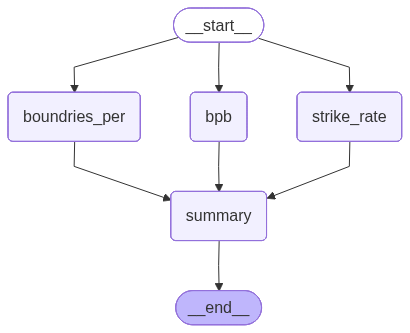

In [26]:
workflow

In [27]:
# execute the graph
initial_state: cricket_stats = {
    "runs": 120,
    "balls": 80,
    "fours": 10,
    "sixes": 5
}   
final_state = workflow.invoke(initial_state)
print(final_state)


{'runs': 120, 'balls': 80, 'fours': 10, 'sixes': 5, 'boundries_per': 18.75, 'strike_rate': 150.0, 'bpb': 5.333333333333333, 'summary': "This cricket player delivered an **explosive and dominant batting performance**. They scored a significant **120 runs off just 80 balls**, showcasing excellent aggressive intent. Their high **strike rate of 150.00** clearly indicates they were scoring quickly and putting the opposition under pressure. The player found the boundary frequently, hitting **10 fours and 5 sixes**, which accounted for **18.75% of their total runs**. On average, they were hitting a boundary every **5.33 balls**, further emphasizing their attacking approach and ability to punish loose deliveries. Overall, a superb innings that significantly contributed to their team's score."}


# llm parellel

In [1]:
from langgraph.graph import StateGraph ,START,END
from typing import TypedDict,Annotated
import google.generativeai as genai
from pydantic import BaseModel,Field
import operator
from langchain.messages import SystemMessage , HumanMessage
from dotenv import load_dotenv
from langchain_google_genai import ChatGoogleGenerativeAI
import os

load_dotenv()

os.environ["GOOGLE_API_KEY"] = os.getenv("gen_api")

model = ChatGoogleGenerativeAI(model="gemini-2.5-flash-lite")

/home/user171125/miniconda3/envs/mindenv/lib/python3.10/site-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.19) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)


In [2]:
class tweet(BaseModel):
    post:str =Field(description="make it original for posting")

In [3]:
class evaluation_essay(BaseModel):

    feedback:str = Field(description ="give detail feedback")
    score:int = Field(description="scoring out of 10",ge=0,ls=10)

In [4]:
structured_model = model.with_structured_output(evaluation_essay)
structured_model2 =model.with_structured_output(tweet)

In [5]:
class upsc_state(TypedDict):

    essay : str 

    lang_feed : str

    analysis_feed : str

    clarity_feed : str

    summary_feed : str
    
    individual_score : Annotated[list[int],operator.add]
    
    avg_score : float
    
    post : str

In [17]:
def lang_feed(state: upsc_state):
    prompt=f"""evaluate the language quality and give the perfect feedback on given essay /n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'lang_feed': output.feedback ,'individual_score':[output.score]}

def analysis_feed(state: upsc_state):
    prompt=f"""evaluate the depth of analysis and give the perfect feedback on given essay /n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'analysis_feed': output.feedback ,'individual_score':[output.score]}

def clarity_feed(state: upsc_state):
    prompt=f"""evaluate the clarity of tougth and give the perfect feedback on given essay /n {state['essay']}"""
    output = structured_model.invoke(prompt)
    return {'clarity_feed': output.feedback ,'individual_score':[output.score]}

def summary_feed(state: upsc_state):
    prompt= f"""provide a summary feedback on essay based on following feedback \n {state['essay']}, on the bases of this feed backs 1. language quality {lang_feed}
            2. depth of analysis {analysis_feed} 
            3. clarity of taught {clarity_feed} """
    output = model.invoke(prompt)
    avg_score = sum(state ['individual_score'])/len(state ['individual_score'])
    return {'summary_feed': output.content, 'avg_score':avg_score}

def llm_clarity(state : upsc_state):
    prompt=[HumanMessage(content=f"""
                         make sure you understand this summery {state["summary_feed"]} and make a post for tweet and make it original 
                         """)]
    response= structured_model2.invoke(prompt)
    return {"post":response}


In [18]:
graph = StateGraph(upsc_state)

graph.add_node("lang_feed",lang_feed)
graph.add_node("analysis_feed",analysis_feed)
graph.add_node("clarity_feed",clarity_feed)
graph.add_node("summary_feed",summary_feed)
graph.add_node("llm_clarity",llm_clarity)


graph.add_edge(START,"lang_feed")
graph.add_edge(START,"analysis_feed")
graph.add_edge(START,"clarity_feed")
graph.add_edge("lang_feed","summary_feed")
graph.add_edge("analysis_feed","summary_feed")
graph.add_edge("clarity_feed","summary_feed")
graph.add_edge("summary_feed","llm_clarity")
graph.add_edge("llm_clarity",END)


workflow = graph.compile()


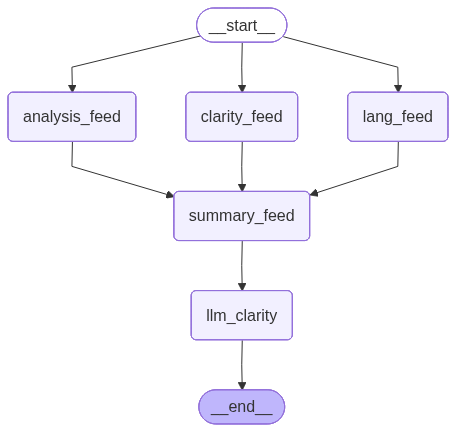

In [19]:
workflow

In [20]:
essay1= "Reading is good but many people not doing it and this is not good because books is important for everybody mind and growing. When I was small I read many book but now people only mobile and that is making many problem for society because reading is best and also very important. Books give knowledge and other things also but sometime people don’t understand. So reading should be do because it make brain sharp and also good habits is come. So this why reading book is very good for the future and people should read more but they not reading that much so problem happening."
essay2 = """Reading books remains one of the most powerful ways to expand knowledge, strengthen critical-thinking skills, and develop imagination. Unlike fast digital content, books encourage deep engagement with ideas and allow readers to explore different perspectives at their own pace. Through reading, individuals improve their vocabulary, communication skills, and overall language fluency.
         Beyond academic benefits, books provide emotional and psychological enrichment. They offer comfort, inspiration, and the ability to experience worlds beyond one’s own. This makes reading not only an intellectual activity but also a meaningful personal journey.
         In a world increasingly dominated by short-form content and distractions, cultivating the habit of reading is essential. It helps people think more clearly, understand others more deeply, and make better decisions. For these reasons, reading books continues to be a timeless and invaluable practice."""

In [21]:
initial_state = {"essay" : essay2}
workflow.invoke(initial_state)


{'essay': 'Reading books remains one of the most powerful ways to expand knowledge, strengthen critical-thinking skills, and develop imagination. Unlike fast digital content, books encourage deep engagement with ideas and allow readers to explore different perspectives at their own pace. Through reading, individuals improve their vocabulary, communication skills, and overall language fluency.\n         Beyond academic benefits, books provide emotional and psychological enrichment. They offer comfort, inspiration, and the ability to experience worlds beyond one’s own. This makes reading not only an intellectual activity but also a meaningful personal journey.\n         In a world increasingly dominated by short-form content and distractions, cultivating the habit of reading is essential. It helps people think more clearly, understand others more deeply, and make better decisions. For these reasons, reading books continues to be a timeless and invaluable practice.',
 'lang_feed': 'The es